#Project setting


In [1]:
!git clone https://github.com/fuzzythecat/awesome-spacer

Cloning into 'awesome-spacer'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 100 (delta 34), reused 39 (delta 14), pack-reused 27
Receiving objects: 100% (100/100), 1.42 MiB | 11.56 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [2]:
%cd awesome-spacer
!ls

/content/awesome-spacer
data  images  LICENSE  models  notebooks  README.md  train.py


In [3]:
%cd data
!wget 'https://www.dropbox.com/s/3ocgkkr3ueklv19/sejong_corpus.zip?dl=0'
!unzip -qq 'sejong_corpus.zip?dl=0' -d sejong_corpus
%cd ..

/content/awesome-spacer/data
--2019-12-13 23:18:54--  https://www.dropbox.com/s/3ocgkkr3ueklv19/sejong_corpus.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3ocgkkr3ueklv19/sejong_corpus.zip [following]
--2019-12-13 23:18:54--  https://www.dropbox.com/s/raw/3ocgkkr3ueklv19/sejong_corpus.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd3a9db2c1ac8cf79f9f5c81d28.dl.dropboxusercontent.com/cd/0/inline/AuNrCaWl7OPoQqdecQxNNw6RL0BxT82mJVfRwE6CHZtTrSZAqjj-K0i7EzzFeWh3Zgpikf1pAZDb6Th8IoE53gHHn-a0b7idPWkGDfhHNP-CzUIOqoax-AesL6-ULO89WjE/file# [following]
--2019-12-13 23:18:54--  https://ucd3a9db2c1ac8cf79f9f5c81d28.dl.dropboxusercontent.com/cd/0/inline/AuNrCaWl7OPoQqdecQxNNw6RL0BxT82mJVfRwE6CHZtTrSZAqjj-K0i7EzzFeWh3Z

In [4]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 3.8MB 49.8MB/s 
     |████████████████████████████████| 450kB 74.2MB/s 
     |████████████████████████████████| 81kB 13.9MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.2 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exist

In [5]:
# Check that TensorFlow 2.0 is installed correctly.
import tensorflow as tf
tf.__version__

'2.0.0'

# Model configuration

In [0]:
import os
import argparse
import sys
from random import shuffle
from glob import glob

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences

from models.config import Config
from models.utils import build_dataset
from models.utils import encode_string
from models.spacer import Spacer

In [0]:
# In Colab / Jupyter Notebook / etc. it is hard to change the contents
# of config.py. Override configuration settings for custom training settings. 
class TrainingConfig(Config):
    BATCH_SIZE = 256
    # Determines N in N-grams.
    # Each element in the list must have a corresponding 
    # filter configuration in `filter_nums`.
    FILTER_SIZES = [4, 6, 8, 10]
    # Determines the number of N-grams features that 
    # are learned. Each element in the list must have a
    # corresponding `N` parameter in `filter_sizes`.
    FILTER_NUMS = [256, 256, 256, 256]
    EPOCHS = 3

config = TrainingConfig()

In [8]:
# Single GPU training.
model = Spacer(None, config) 
optimizer = optimizers.Adam(config.LEARNING_RATE)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',
                       tf.metrics.Precision(),
                       tf.metrics.Recall(),
                       tf.metrics.AUC()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 64)      721216      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 200, 256)     65792       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 200, 256)     98560       embedding[0][0]                  
______________________________________________________________________________________________

In [12]:
# Data preparation
filenames = glob(os.path.join('data/sejong_corpus', '*.txt'))
shuffle(filenames)
filenames = filenames[:100]

validation_split = int(len(filenames) * 0.2)
val_filenames = filenames[:validation_split]
train_filenames =  filenames[validation_split:]

print('Found {} files.'.format(len(filenames)))
print('Using {} files for training.'.format(len(train_filenames)))

Found 100 files.
Using 80 files for training.


In [13]:
X_train, y_train = build_dataset(train_filenames, config) 
X_val, y_val = build_dataset(val_filenames, config)
 
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(config.BATCH_SIZE)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
valid_dataset = valid_dataset.batch(config.BATCH_SIZE)
valid_dataset = valid_dataset.repeat()

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_val.shape: ', X_val.shape)
print('y_val.shape: ', y_val.shape)

100%|██████████| 20/20 [00:00<00:00, 12.98it/s]


X_train.shape:  (38371, 200)
y_train.shape:  (38371, 200)
X_val.shape:  (12096, 200)
y_val.shape:  (12096, 200)


In [14]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=config.EPOCHS,
                    steps_per_epoch=len(X_train)//config.BATCH_SIZE,
                    validation_steps=len(X_val)//config.BATCH_SIZE,
                    verbose=1)

Train for 149 steps, validate for 47 steps
Epoch 1/3
149/149 [==============================] - 38s 253ms/step - loss: 0.3332 - accuracy: 0.8429 - precision: 0.8356 - recall: 0.3463 - auc: 0.8644 - val_loss: 0.1607 - val_accuracy: 0.9354 - val_precision: 0.8624 - val_recall: 0.8499 - val_auc: 0.9767
Epoch 2/3
149/149 [==============================] - 28s 186ms/step - loss: 0.1348 - accuracy: 0.9456 - precision: 0.8952 - recall: 0.8488 - auc: 0.9824 - val_loss: 0.1374 - val_accuracy: 0.9439 - val_precision: 0.9192 - val_recall: 0.8240 - val_auc: 0.9827
Epoch 3/3
149/149 [==============================] - 27s 184ms/step - loss: 0.1151 - accuracy: 0.9535 - precision: 0.9116 - recall: 0.8702 - auc: 0.9870 - val_loss: 0.1188 - val_accuracy: 0.9513 - val_precision: 0.9271 - val_recall: 0.8512 - val_auc: 0.9868


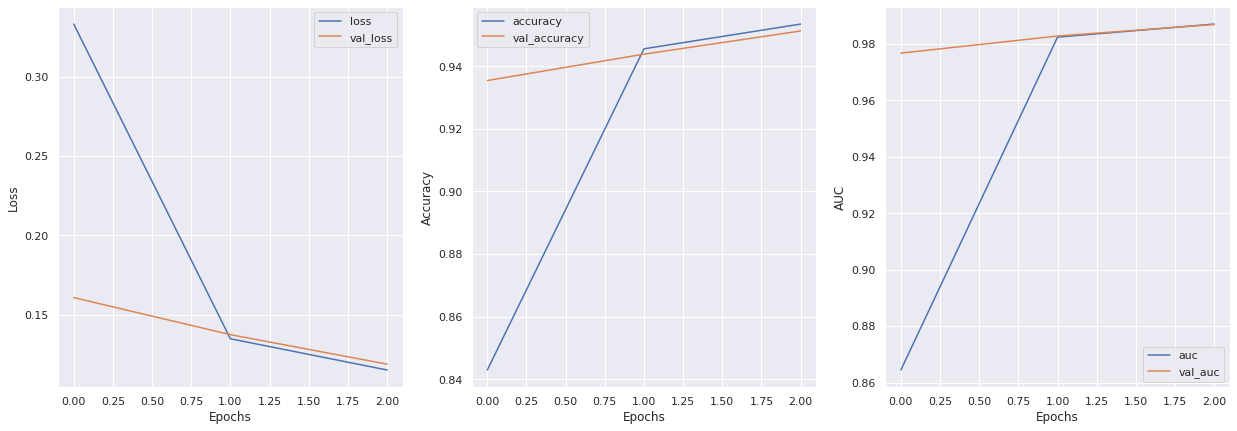

In [15]:
hist = history.history

plt.figure(figsize=(21,7))
plt.subplot(1, 3, 1)
plt.plot(range(config.EPOCHS), hist['loss'], label='loss')
plt.plot(range(config.EPOCHS), hist['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(1, 3, 2)
plt.plot(range(config.EPOCHS), hist['accuracy'], label='accuracy')
plt.plot(range(config.EPOCHS), hist['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(1, 3, 3)
plt.plot(range(config.EPOCHS), hist['auc'], label='auc')
plt.plot(range(config.EPOCHS), hist['val_auc'], label='val_auc')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='best')

plt.show()

In [16]:

tests = [ '''아무튼 동아시아에도 상투를 자르기 전에 내 목을 먼저 쳐라, 
예의의 나라가 어떻게 양이의 법도를 따르겠냐라며 엄청난 저항이 있었지만, 
결국 서구문명을 완전히 받아들이고 흡수했습니다.''',
    
    '''내가그린기린그림은긴기린그린그림이고, 
네가그린기린그림은길지않은기린그린그림이다.''',

    '''병원에 응급 환자가 실려 왔다. 클리블랜드에게 3쿼터 막판~4쿼터 초반 구간 0-24 런(RUN) 일방적인 
폭행을 당했던 휴스턴이다. 러셀 웨스트브룩, 클린트 카펠라 등 수련생들은 어찌할 바를 몰라
발을 동동 굴렀다. 여기서 전문의 털보 선생님 등장. "모두 물러나라. 내가 치료하겠다." 
환자는 '털보네이터'의 자상한 개인 전술 기반 연속 13득점 시술을 받은 후 기적적으로 소생했다. 
털보는 팀이 4쿼터 마지막 8분 구간에서 기록한 28득점 중 23득점을 생산한 후 유유히 퇴근한다.
(본인 20득점+AST 기반 동료 3점) 3점슛 10개 포함 55득점(FG 20/34)은 치료비다. ''',

    '''경기후 컨퍼런스 무리뉴 : 난 그런 기분이 들었어, 예전에 알렉스 퍼거슨 경이 
호랑이 얘기 한거 나는 기억하거든? 아마 이런 건 문화적인 것이겠지. 지성 팍과 
손, 둘다 감독으로서 지도하기 정말 좋은 선수들이야. 손흥민은 판타스틱해. 
나는 기뻐, 정말로! - 국뽕코인 탑승하는 무버지''']

# Remove whitespaces
tests = [''.join(t.split()) for t in tests]
encoded = [encode_string(t, config.CHR_TO_IDX) for t in tests]
encoded = pad_sequences(encoded, maxlen=config.MAX_TEXT_LEN, 
                        padding='post', truncating='post',
                        value=config.CHR_TO_IDX['<PAD>'])

probs = model.predict([encoded])

for i, t in enumerate(tests):
    print('#{}: '.format(i+1))
    for j, c in enumerate(t[:config.MAX_TEXT_LEN]):
        print(c, end='')
        if probs[i][j] >= 0.5:
            print(' ', end='')
    print('\n')

#1: 
아무튼 동아시아에도 상투를 자르기 전에 내목을 먼저 쳐라, 예의의 나라가 어떻게 양이의 법도를 따르겠냐라며 엄청난 저항이 있었지만, 결국서구 문명을 완전히 받아들이고 흡수했습니다.

#2: 
내가 그린 기린 그림은 긴기린 그린 그림이고, 네가 그린 기린 그림은 길지 않은 기린 그린 그림이다.

#3: 
병원에 응급환자가 실려왔다. 클리블 랜드에게 3쿼터 막판~ 4쿼터 초반구간0-24런(RUN) 일방적인 폭행을 당했던 휴스턴이다. 러셀웨스트브룩, 클린트카펠라 등 수련생들은 어찌할 바를 몰라발을 동동굴렀다. 여기서 전문의 털보 선생님 등장." 모두 물러나라. 내가 치료하겠다." 환자는 '털보네이터'의 자상한 개인전술기반연속 13득점 시술을 받은 후기적적으로 소생했다. 털보는 팀이 4쿼터 마지막 8분구간에서 기록한 28득점중 23득점을 생산한 

#4: 
경기 후컨퍼런 스무리뉴 :난 그런 기분이 들었어, 예전에 알렉스퍼 거슨 경이 호랑이 얘기한 거나는 기억하거든? 아마이런 건 문화적인 것이겠지.지 성팍과 손, 둘다 감독으로서지도 하기 정말 좋은 선수들이야. 손흥민은 판타스틱해. 나는 기뻐, 정말로! -국뽕코인 탑승하는 무버지

